<a href="https://colab.research.google.com/github/Sivaram-G97/Python_Projects/blob/main/Bird_Migration_Analysis/Bird_Migration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary libraries


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import geopandas as gpd
from shapely.geometry import Point


In [ ]:
df = pd.read_excel('/content/Bird_Migration_data.xlsx')

In [ ]:
df.head(5)

,Bird_ID,Species,Region,Habitat,Weather_Condition,Migration_Reason,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,...,Tracking_Quality,Migration_Interrupted,Interrupted_Reason,Tagged_By,Tag_Weight_g,Migration_Success,Recovery_Location_Known,Recovery_Time_days,Observation_Counts,Observation_Quality
0,B1000,Warbler,South America,Grassland,Stormy,Feeding,11.906566,-169.378251,30.377647,-21.366879,...,Excellent,Yes,Storm,Researcher_A,27.0,Failed,No,102,56,Low
1,B1001,Stork,North America,Grassland,Stormy,Breeding,62.301546,-111.475069,39.921092,47.963436,...,Good,Yes,Injury,Researcher_C,14.2,Successful,Yes,118,61,Low
2,B1002,Hawk,South America,Mountain,Stormy,Avoid Predators,87.861164,-78.727327,66.990980,19.448466,...,Fair,No,Lost Signal,Researcher_B,16.1,Failed,No,41,71,High
3,B1003,Warbler,South America,Urban,Stormy,Climate Change,35.770590,153.104341,-49.003145,-157.868744,...,Good,Yes,Lost Signal,Researcher_C,24.4,Successful,No,15,68,Low
4,B1004,Crane,Europe,Urban,Windy,Avoid Predators,-21.611614,106.674824,11.681051,-115.022863,...,Good,No,NaN,Researcher_B,25.8,Failed,Yes,73,67,Moderate


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Bird_ID                  10000 non-null  object 
 1   Species                  10000 non-null  object 
 2   Region                   10000 non-null  object 
 3   Habitat                  10000 non-null  object 
 4   Weather_Condition        10000 non-null  object 
 5   Migration_Reason         10000 non-null  object 
 6   Start_Latitude           10000 non-null  float64
 7   Start_Longitude          10000 non-null  float64
 8   End_Latitude             10000 non-null  float64
 9   End_Longitude            10000 non-null  float64
 10  Flight_Distance_km       10000 non-null  float64
 11  Flight_Duration_hours    10000 non-null  float64
 12  Average_Speed_kmph       10000 non-null  float64
 13  Max_Altitude_m           10000 non-null  int64  
 14  Min_Altitude_m         

In [ ]:
df.describe()

,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,Flight_Distance_km,Flight_Duration_hours,Average_Speed_kmph,Max_Altitude_m,Min_Altitude_m,Temperature_C,...,Pressure_hPa,Visibility_km,Tag_Battery_Level_%,Signal_Strength_dB,Rest_Stops,Predator_Sightings,Flock_Size,Tag_Weight_g,Recovery_Time_days,Observation_Counts
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.321812,-0.394588,0.084391,0.467617,2504.036134,49.994020,49.953394,5504.80830,500.111800,12.566930,...,1000.440810,10.636970,54.651800,-69.8408,7.380000,4.490200,248.714500,17.605870,60.490800,49.872800
std,51.919190,104.083440,51.709437,103.438134,499.723298,10.026108,5.085296,2595.28577,229.782907,13.073405,...,28.959614,5.504623,25.839271,9.9189,4.023583,2.872826,144.943771,7.200088,34.434028,28.601997
min,-89.999003,-179.993975,-89.998482,-179.902756,527.700000,12.600000,30.430000,1000.00000,100.000000,-10.000000,...,950.000000,1.000000,10.000000,-107.9000,1.000000,0.000000,1.000000,5.000000,1.000000,1.000000
25%,-45.390697,-91.444680,-43.664719,-88.871564,2169.632500,43.200000,46.530000,3277.75000,300.000000,1.200000,...,975.000000,5.900000,32.000000,-76.6000,4.000000,2.000000,124.000000,11.400000,31.000000,25.000000
50%,-0.138849,-0.479892,-0.163116,1.280823,2511.150000,50.050000,50.040000,5521.00000,501.000000,12.500000,...,1000.950000,10.700000,55.000000,-69.8000,7.000000,5.000000,248.000000,17.700000,61.000000,50.000000
75%,44.480926,89.640253,44.957102,91.196076,2841.452500,56.800000,53.360000,7740.25000,698.000000,24.000000,...,1025.500000,15.400000,77.000000,-63.1000,11.000000,7.000000,376.000000,24.000000,91.000000,74.000000
max,89.980302,179.989973,89.989145,179.955036,4428.320000,91.000000,68.950000,9999.00000,899.000000,35.000000,...,1050.000000,20.000000,99.000000,-33.3000,14.000000,9.000000,499.000000,30.000000,119.000000,99.000000


In [ ]:
df.columns

Index(['Bird_ID', 'Species', 'Region', 'Habitat', 'Weather_Condition',
       'Migration_Reason', 'Start_Latitude', 'Start_Longitude', 'End_Latitude',
       'End_Longitude', 'Flight_Distance_km', 'Flight_Duration_hours',
       'Average_Speed_kmph', 'Max_Altitude_m', 'Min_Altitude_m',
       'Temperature_C', 'Wind_Speed_kmph', 'Humidity_%', 'Pressure_hPa',
       'Visibility_km', 'Nesting_Success', 'Tag_Battery_Level_%',
       'Signal_Strength_dB', 'Migration_Start_Month', 'Migration_End_Month',
       'Rest_Stops', 'Predator_Sightings', 'Tag_Type', 'Migrated_in_Flock',
       'Flock_Size', 'Food_Supply_Level', 'Tracking_Quality',
       'Migration_Interrupted', 'Interrupted_Reason', 'Tagged_By',
       'Tag_Weight_g', 'Migration_Success', 'Recovery_Location_Known',
       'Recovery_Time_days', 'Observation_Counts', 'Observation_Quality'],
      dtype='object')

In [ ]:
df.dtypes

,0
Bird_ID,object
Species,object
Region,object
Habitat,object
Weather_Condition,object
Migration_Reason,object
Start_Latitude,float64
Start_Longitude,float64
End_Latitude,float64
End_Longitude,float64


In [ ]:
df.isnull().sum()

,0
Bird_ID,0
Species,0
Region,0
Habitat,0
Weather_Condition,0
Migration_Reason,0
Start_Latitude,0
Start_Longitude,0
End_Latitude,0
End_Longitude,0


#Handling Missing Values

# --- Imputing missing 'Interrupted_Reason' based on group consistency ---

* To facilitate group-based imputation, we will first round the 'Start_Latitude' and 'Start_Longitude' to two decimal places. This effectively groups locations within a roughly 10km radius.

* We will group the bird migration data by 'Species', 'Start_Latitude', 'Start_Longitude', and 'Migration_Start_Month'. The goal is to leverage instances where at least one bird within such a specific group has a recorded 'Interrupted_Reason'.

* If we find a reason, we will propagate that same reason to all other birds in the same group with missing 'Interrupted_Reason'.

* The underlying assumption is that birds sharing these characteristics (species, starting point, and migration start time) are more likely to experience the same causes for migration interruption.

* Before attempting the imputation, we will first verify if it's feasible by checking if each group contains at least one non-null 'Interrupted_Reason' value.

In [ ]:
missing_reason_df = df[df['Interrupted_Reason'].isnull()]

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy['Start_Latitude'] = df_copy['Start_Latitude'].round(1)
df_copy['Start_Longitude'] = df_copy['Start_Longitude'].round(1)

In [ ]:
df_copy['Start_Longitude'].head(10)

,Start_Longitude
0,-169.4
1,-111.5
2,-78.7
3,153.1
4,106.7
5,138.3
6,-21.4
7,116.1
8,127.3
9,-36.0


In [ ]:
len(df_copy['Start_Longitude'].unique())


3379

In [ ]:
len(df_copy['Start_Latitude'].unique())

1796

In [ ]:
grouping_cols = ['Species', 'Start_Latitude', 'Start_Longitude', 'Migration_Start_Month']
reason_col = 'Interrupted_Reason'

grouped = df_copy.groupby(grouping_cols)

In [ ]:
def can_impute_simple(group):
    has_non_null = group[reason_col].notna().any()
    has_null = group[reason_col].isnull().any()
    return has_non_null and has_null

In [ ]:
imputation_possible = grouped.apply(can_impute_simple).any()


<ipython-input-17-da5ea8e9b1f0>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  imputation_possible = grouped.apply(can_impute_simple).any()


In [ ]:
print(imputation_possible)

False


Now it's evident that imputation isn't possible


# Univariate Analysis
## Checking for Outliers and spread


Text(0.5, 1.0, 'Distribution of Flight Distances')

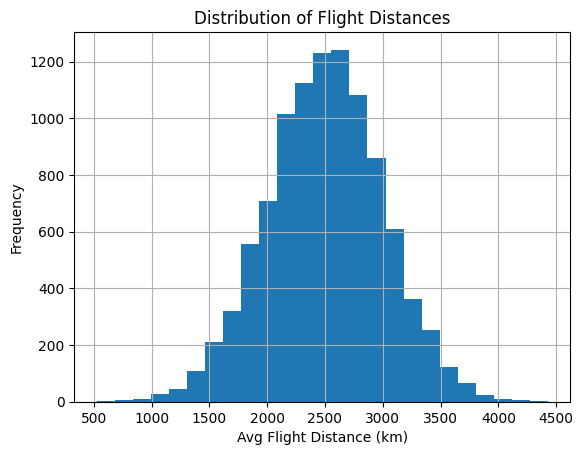

In [ ]:
df['Flight_Distance_km'].hist(bins=25)
plt.xlabel('Avg Flight Distance (km)')
plt.ylabel('Frequency')
plt.title('Distribution of Flight Distances')

Text(0.5, 1.0, 'Distribution of Flight hours')

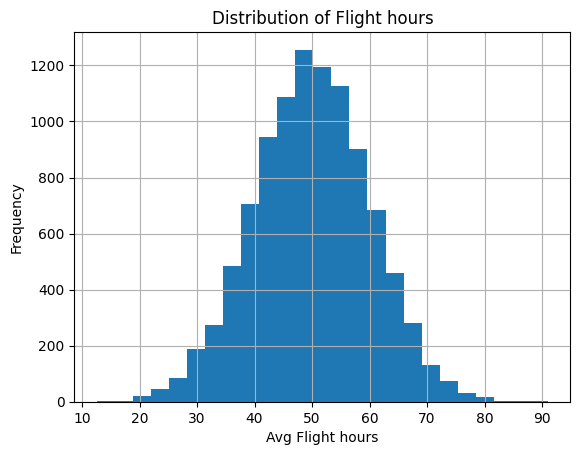

In [ ]:
df['Flight_Duration_hours'].hist(bins=25)
plt.xlabel('Avg Flight hours')
plt.ylabel('Frequency')
plt.title('Distribution of Flight hours')

Text(0.5, 1.0, 'Distribution of Average Speed')

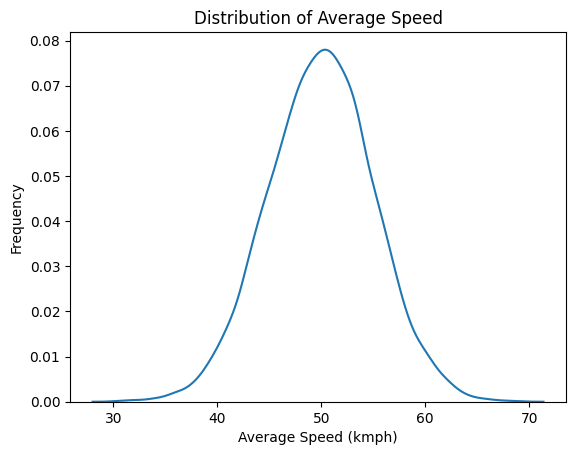

In [ ]:
sns.kdeplot(df['Average_Speed_kmph'])
plt.xlabel('Average Speed (kmph)')
plt.ylabel('Frequency')
plt.title('Distribution of Average Speed')

In [ ]:
altitude_data = df[['Max_Altitude_m', 'Min_Altitude_m']].melt(var_name = 'Altitude_Type', value_name = 'Altitude')

Text(0.5, 1.0, 'Distribution of Altitude')

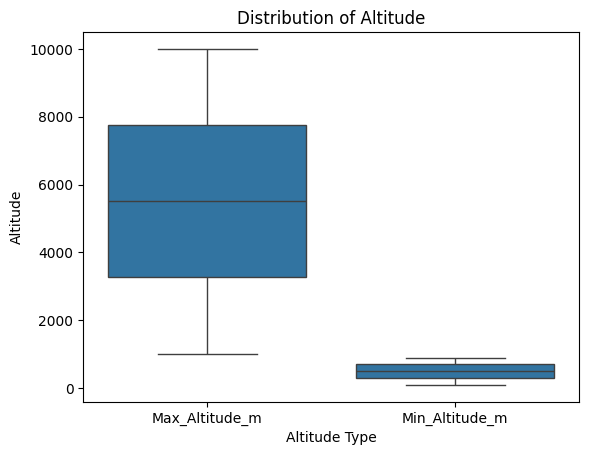

In [ ]:
sns.boxplot(x = 'Altitude_Type', y = 'Altitude', data = altitude_data)
plt.xlabel('Altitude Type')
plt.ylabel('Altitude')
plt.title('Distribution of Altitude')

Text(0.5, 1.0, 'Distribution of Temperature')

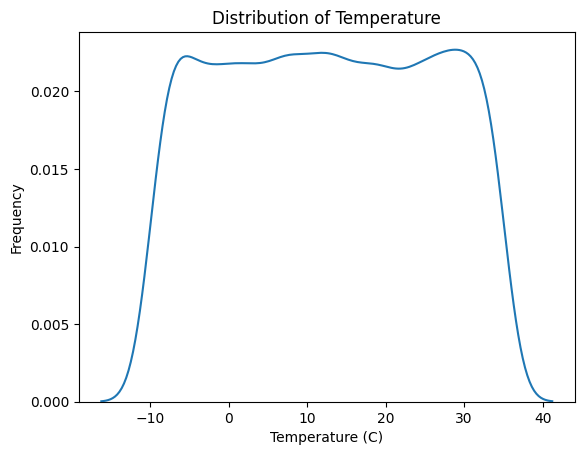

In [ ]:
sns.kdeplot(df['Temperature_C'])
plt.xlabel('Temperature (C)')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature')

Text(0.5, 1.0, 'Distribution of Wind Speed')

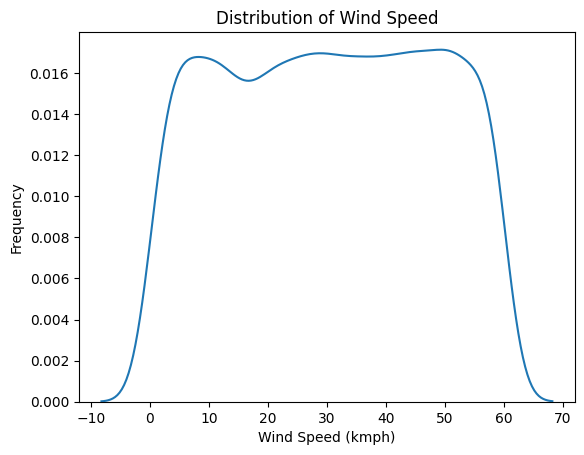

In [ ]:
sns.kdeplot(df['Wind_Speed_kmph'])
plt.xlabel('Wind Speed (kmph)')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Speed')

Text(0.5, 1.0, 'Distribution of Humidity')

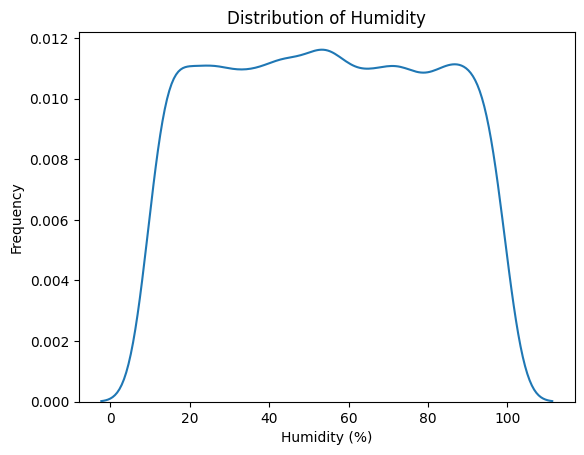

In [ ]:
sns.kdeplot(df['Humidity_%'])
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Humidity')

Text(0.5, 1.0, 'Distribution of Pressure')

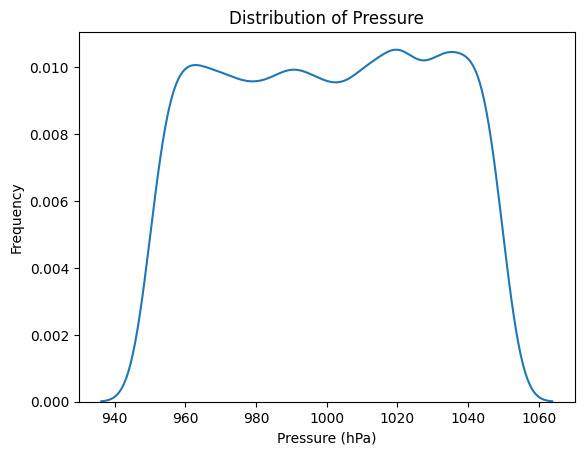

In [ ]:
sns.kdeplot(df['Pressure_hPa'])
plt.xlabel('Pressure (hPa)')
plt.ylabel('Frequency')
plt.title('Distribution of Pressure')

Text(0.5, 1.0, 'Distribution of Visibility')

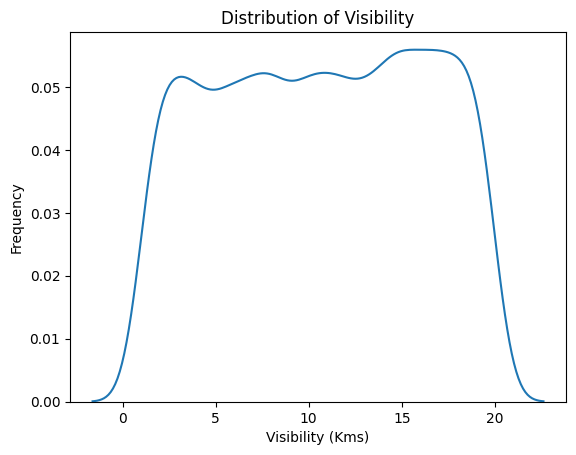

In [ ]:
sns.kdeplot(df['Visibility_km'])
plt.xlabel('Visibility (Kms)')
plt.ylabel('Frequency')
plt.title('Distribution of Visibility')

Text(0.5, 1.0, 'Distribution of Species')

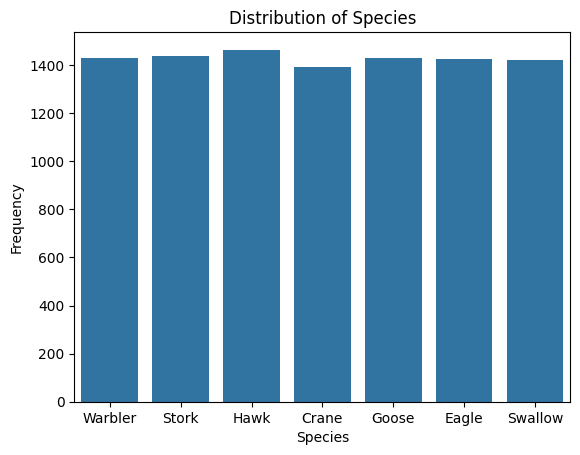

In [ ]:
sns.countplot(x = 'Species', data = df)
plt.xlabel('Species')
plt.ylabel('Frequency')
plt.title('Distribution of Species')

Text(0.5, 1.0, 'Distribution of Region')

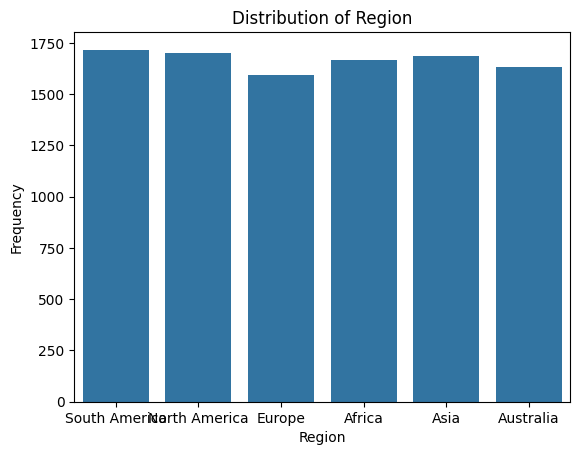

In [ ]:
sns.countplot(x='Region', data = df)
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.title('Distribution of Region')

Text(0.5, 1.0, 'Distribution of Habitat')

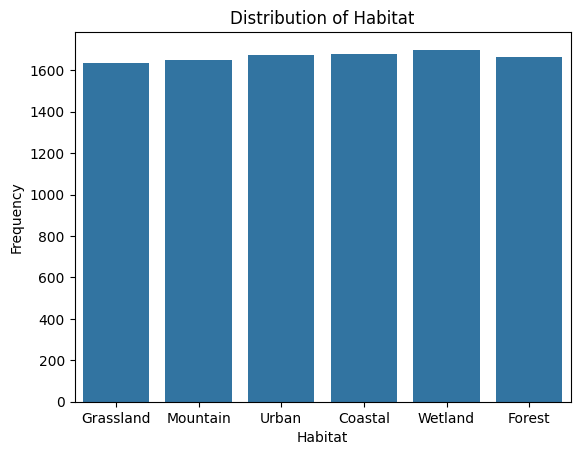

In [ ]:
sns.countplot(x = 'Habitat', data = df)
plt.xlabel('Habitat')
plt.ylabel('Frequency')
plt.title('Distribution of Habitat')

Text(0.5, 1.0, 'Distribution of Weather Condition')

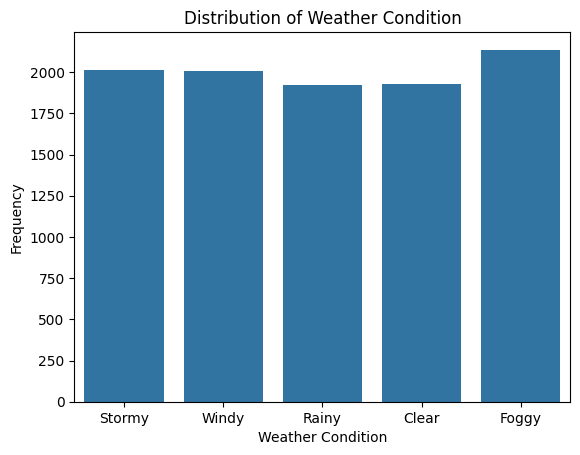

In [ ]:
sns.countplot(x = 'Weather_Condition', data = df)
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.title('Distribution of Weather Condition')

Text(0.5, 1.0, 'Distribution of Migration Reason')

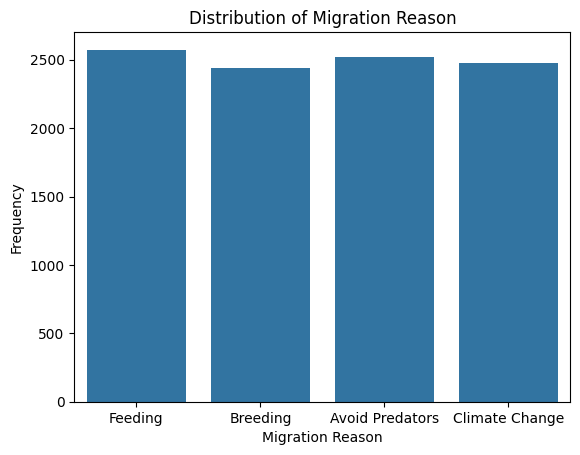

In [ ]:
sns.countplot(x = 'Migration_Reason', data = df)
plt.xlabel('Migration Reason')
plt.ylabel('Frequency')
plt.title('Distribution of Migration Reason')

In [ ]:
df.columns

Index(['Bird_ID', 'Species', 'Region', 'Habitat', 'Weather_Condition',
       'Migration_Reason', 'Start_Latitude', 'Start_Longitude', 'End_Latitude',
       'End_Longitude', 'Flight_Distance_km', 'Flight_Duration_hours',
       'Average_Speed_kmph', 'Max_Altitude_m', 'Min_Altitude_m',
       'Temperature_C', 'Wind_Speed_kmph', 'Humidity_%', 'Pressure_hPa',
       'Visibility_km', 'Nesting_Success', 'Tag_Battery_Level_%',
       'Signal_Strength_dB', 'Migration_Start_Month', 'Migration_End_Month',
       'Rest_Stops', 'Predator_Sightings', 'Tag_Type', 'Migrated_in_Flock',
       'Flock_Size', 'Food_Supply_Level', 'Tracking_Quality',
       'Migration_Interrupted', 'Interrupted_Reason', 'Tagged_By',
       'Tag_Weight_g', 'Migration_Success', 'Recovery_Location_Known',
       'Recovery_Time_days', 'Observation_Counts', 'Observation_Quality'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of Migration End Month')

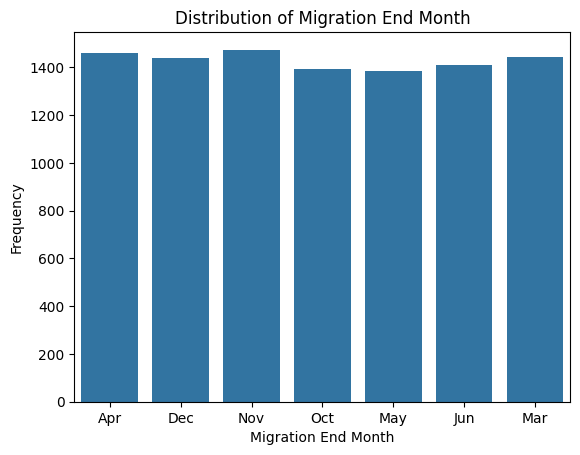

In [ ]:
sns.countplot(x = 'Migration_End_Month', data = df)
plt.xlabel('Migration End Month')
plt.ylabel('Frequency')
plt.title('Distribution of Migration End Month')

Text(0.5, 1.0, 'Distribution of Migration Start Month')

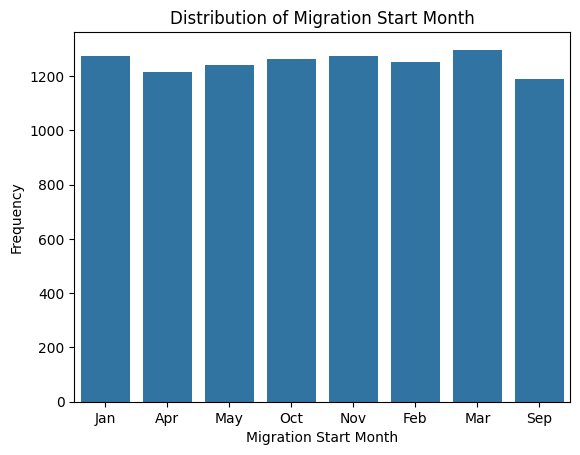

In [ ]:
sns.countplot(x = 'Migration_Start_Month', data = df)
plt.xlabel('Migration Start Month')
plt.ylabel('Frequency')
plt.title('Distribution of Migration Start Month')

The univariate analysis conducted on the numerical columns **('Flight_Distance_Km', 'Flight_Duration_hours', 'Average_Speed_kmph', 'Max_Altitude_m', 'Min_Altitude_m', 'Temperature_C', 'Wind_Speed_kmph', 'Humidity_%', 'Pressure_hPa', 'Visibility_km')** reveals a lack of significant outliers and minimal skewness in their distributions. Similarly, the categorical columns **('Species', 'Region', 'Habitat', 'Weather_Condition', 'Migration_Reason')** show the frequency of each category.

## Findings from Univariate Analysis:

* The Typical flight distance of the birds is between 2000 kms - 3000 kms

* Most birds have a flight hour between 35 hrs to 65 hrs

* The peak migration periods appear to be:

    * Starts: Primarily around March, with significant activity also in January, October, November, and February.

    * Ends: Primarily around April and November, with considerable activity also in March and December.

# Other Considerations


Here, We're going to consider the following as the 'Interrupted_Reason' being present alongside 'Migration_Success' as 'Successful',

* **Temporary Interruption:** The recorded interruption (e.g., storm, minor injury, lost signal) might have been temporary, allowing the bird to resume and successfully complete its migration.

* **Partial Migration Success:** 'Migration_Success' might be defined based on reaching a general destination or breeding grounds, even if a part of the journey experienced an interruption.


In [ ]:
df[['Interrupted_Reason' ,'Migration_Success']].head(15)

,Interrupted_Reason,Migration_Success
0,Storm,Failed
1,Injury,Successful
2,Lost Signal,Failed
3,Lost Signal,Successful
4,NaN,Failed
5,Lost Signal,Failed
6,Predator,Successful
7,Injury,Failed
8,Lost Signal,Failed
9,Predator,Successful


# Question 1:

## Do certain species migrate in larger flocks?

In [ ]:
df[['Migrated_in_Flock', 'Species', 'Flock_Size']].head(15)

,Migrated_in_Flock,Species,Flock_Size
0,Yes,Warbler,264
1,Yes,Stork,212
2,Yes,Hawk,340
3,No,Warbler,484
4,No,Crane,184
5,Yes,Hawk,451
6,Yes,Hawk,278
7,Yes,Warbler,130
8,No,Goose,385
9,Yes,Crane,209


## Considerations
###  **Note on 'Migrated_in_Flock' and 'Flock_Size':** Although 'Migrated_in_Flock' might be marked as 'No', the 'Flock_Size' column contains values other than zero. As its a synthetic data we take the following into considerations

* **Individual Tracking within a Flock:** Even if the overall Migrated_in_Flock is marked as 'No' for a specific bird, the Flock_Size might still represent the size of a flock it was observed with at some point during its migration, even if it wasn't considered to be actively migrating as part of that flock for the entire journey.

* **Initial or Final Observation:** The Flock_Size recorded might be the size of a group the bird was seen with at the beginning of its migration before separating, or at the end when joining others at a destination. The 'Migrated_in_Flock' status might refer to the majority of the migration journey.

* **"No" Meaning "Not Primarily in a Flock":** The 'No' in Migrated_in_Flock might not strictly mean the bird was entirely alone for its entire migration. It could indicate that its primary mode of migration was solitary, even if it occasionally encountered or briefly traveled with other birds. The Flock_Size might capture these instances.

In [ ]:
df.groupby(['Migrated_in_Flock', 'Species'])['Flock_Size'].count()

Migrated_in_Flock  Species
No                 Crane      698
                   Eagle      713
                   Goose      683
                   Hawk       694
                   Stork      700
                   Swallow    689
                   Warbler    714
Yes                Crane      693
                   Eagle      713
                   Goose      745
                   Hawk       770
                   Stork      739
                   Swallow    734
                   Warbler    715
Name: Flock_Size, dtype: int64

In [ ]:
Migrated_in_Flock_df = df[df['Migrated_in_Flock'] == 'Yes']

Text(0, 0.5, 'Frequency')

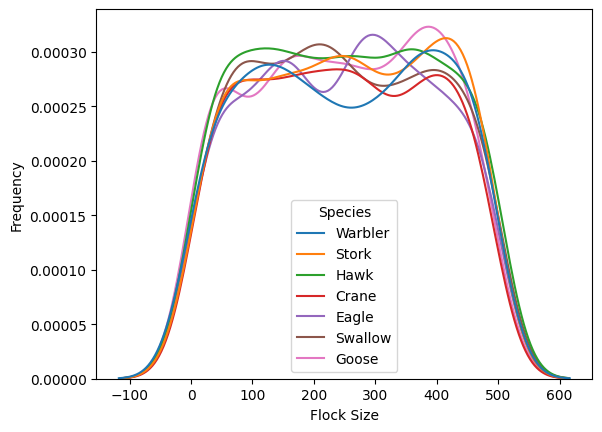

In [ ]:
sns.kdeplot(x = 'Flock_Size', hue = 'Species', data = Migrated_in_Flock_df)
plt.xlabel('Flock Size')
plt.ylabel('Frequency')

## Findings:

* Geese display a clear peak in the larger flock size range (around 350-500), suggesting that when Geese migrate in flocks, they typically form larger groups compared to most other species in this selection.

In [ ]:
df['Migrated_in_Flock'].value_counts()

,count
Migrated_in_Flock,
Yes,5109
No,4891


# Question 2:

## How does weather impact nesting success?

## Chi - Squared Test

In [ ]:
contingency_table = pd.crosstab(df['Weather_Condition'], df['Nesting_Success'])

In [ ]:
print(contingency_table)

Nesting_Success      No   Yes
Weather_Condition            
Clear               954   971
Foggy              1090  1046
Rainy               992   928
Stormy             1032   978
Windy               977  1032


In [ ]:
Chi2, p_value, dof, expected = chi2_contingency(contingency_table)

In [ ]:
print('Chi - Sqared Statistic:', Chi2)
print('P-Value:', p_value)
print('Degrees of Freedom:', dof)
print('Expected Frequency:', expected)

Chi - Sqared Statistic: 5.336733029609694
P-Value: 0.2544578582479056
Degrees of Freedom: 4
Expected Frequency: [[ 971.1625  953.8375]
 [1077.612  1058.388 ]
 [ 968.64    951.36  ]
 [1014.045   995.955 ]
 [1013.5405  995.4595]]


In [ ]:
alpha = 0.05
if p_value < alpha:
    print("\nThe association between Weather Condition and Nesting Success is statistically significant (p < 0.05).")
else:
    print("\nThere is no statistically significant association between Weather_Condition and Nesting_Success (p >= 0.05).")


There is no statistically significant association between Weather_Condition and Nesting_Success (p >= 0.05).


## ANOVA

In [ ]:
numerical_weather = ['Temperature_C', 'Wind_Speed_kmph', 'Humidity_Percent', 'Pressure_hPa', 'Visibility_km']

In [ ]:
df.columns

Index(['Bird_ID', 'Species', 'Region', 'Habitat', 'Weather_Condition',
       'Migration_Reason', 'Start_Latitude', 'Start_Longitude', 'End_Latitude',
       'End_Longitude', 'Flight_Distance_km', 'Flight_Duration_hours',
       'Average_Speed_kmph', 'Max_Altitude_m', 'Min_Altitude_m',
       'Temperature_C', 'Wind_Speed_kmph', 'Humidity_%', 'Pressure_hPa',
       'Visibility_km', 'Nesting_Success', 'Tag_Battery_Level_%',
       'Signal_Strength_dB', 'Migration_Start_Month', 'Migration_End_Month',
       'Rest_Stops', 'Predator_Sightings', 'Tag_Type', 'Migrated_in_Flock',
       'Flock_Size', 'Food_Supply_Level', 'Tracking_Quality',
       'Migration_Interrupted', 'Interrupted_Reason', 'Tagged_By',
       'Tag_Weight_g', 'Migration_Success', 'Recovery_Location_Known',
       'Recovery_Time_days', 'Observation_Counts', 'Observation_Quality'],
      dtype='object')

In [ ]:
df.rename(columns={'Humidity_%': 'Humidity_Percent'}, inplace=True) #stats model might not work properly with special characters

In [ ]:
for col in numerical_weather:
    print(f"\nANOVA for {col} vs. Nesting Success:")
    formula = f'{col} ~ C(Nesting_Success)'
    model = smf.ols(formula, data=df).fit()
    anova_table = anova_lm(model)
    print(anova_table)


ANOVA for Temperature_C vs. Nesting Success:
                        df        sum_sq     mean_sq         F   PR(>F)
C(Nesting_Success)     1.0  1.745509e+02  174.550922  1.021282  0.31224
Residual            9998.0  1.708794e+06  170.913547       NaN      NaN

ANOVA for Wind_Speed_kmph vs. Nesting Success:
                        df        sum_sq     mean_sq        F    PR(>F)
C(Nesting_Success)     1.0  5.471942e+01   54.719420  0.18246  0.669277
Residual            9998.0  2.998381e+06  299.898111      NaN       NaN

ANOVA for Humidity_Percent vs. Nesting Success:
                        df        sum_sq     mean_sq        F    PR(>F)
C(Nesting_Success)     1.0  9.370302e+02  937.030246  1.40034  0.236695
Residual            9998.0  6.690110e+06  669.144786      NaN       NaN

ANOVA for Pressure_hPa vs. Nesting Success:
                        df        sum_sq      mean_sq         F    PR(>F)
C(Nesting_Success)     1.0  1.894516e+03  1894.515622  2.259266  0.132849
Residual        

## **Findings**:

### **Findings from Chi-Squared Test (Categorical Weather Condition):**

The Chi-squared test between 'Weather_Condition' and 'Nesting_Success' yielded a p-value of 0.2545. This p-value is greater than the common significance level of 0.05. Therefore, we fail to reject the null hypothesis.

This indicates that there is no statistically significant association between the categorical weather condition (Clear, Foggy, Rainy, Stormy, Windy) and nesting success in your dataset. The observed distribution of successful and unsuccessful nests across the different weather conditions is not significantly different from what we would expect if there were no relationship between them.

### **Findings from ANOVA (Numerical Weather Variables):**
Based on these ANOVA results, for each of the numerical weather variables tested individually, there is no statistically significant evidence to suggest that the mean weather condition was different for successful nesting events compared to unsuccessful nesting events in the dataset. As the p-value is higher than 0.05.

There is no strong statistical evidence to conclude that weather, as represented by these variables, has a significant impact on nesting success.

# Question 3:

### What conditions lead to migration interruptions?

In [ ]:
df[df['Migration_Interrupted'] == 'Yes']['Interrupted_Reason'].value_counts()

,count
Interrupted_Reason,
Storm,1066
Injury,1011
Predator,1002
Lost Signal,951


## Findings:

In summary, based on this data, the primary conditions leading to recorded migration interruptions appear to be adverse weather (storms), physical injury to the birds, and encounters with predators. Loss of tracking signal is also noted as a reason, but less frequently than the other three.

# Geospatial Analysis

In [ ]:
geometry_start = [Point(xy) for xy in zip(df['Start_Longitude'], df['Start_Latitude'])]
gdf_start = gpd.GeoDataFrame(df, geometry=geometry_start, crs="EPSG:4326")

In [ ]:
geometry_end = [Point(xy) for xy in zip(df['End_Longitude'], df['End_Latitude'])]
gdf_end = gpd.GeoDataFrame(df, geometry=geometry_end, crs="EPSG:4326")

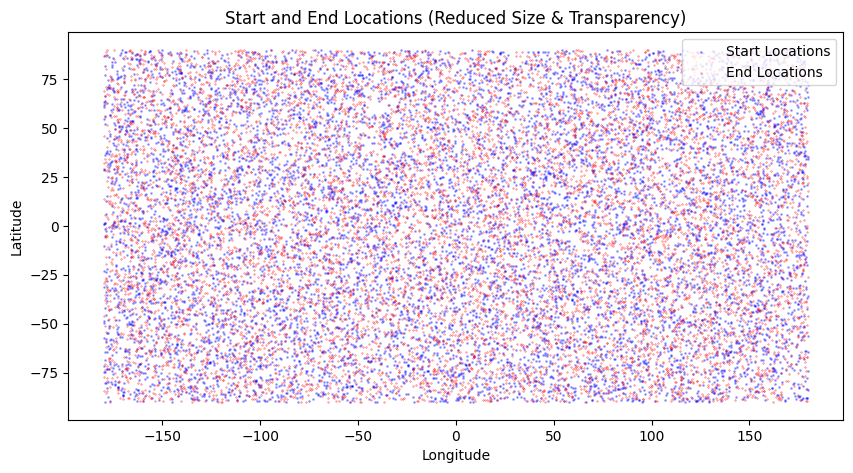

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf_start.plot(ax=ax, marker='o', color='blue', markersize=1, alpha=0.3, label='Start Locations')
gdf_end.plot(ax=ax, marker='x', color='red', markersize=1, alpha=0.3, label='End Locations')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Start and End Locations (Reduced Size & Transparency)")
ax.legend(loc='upper right')
plt.show()